In [27]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import seaborn as sns

from foods.dashboard import read_database, find_item, make_data, meal_plots, nuts_plots

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
foods = read_database()
find_item('coconut', foods)

,ingredient,category,fat,carbs,sugar,fiber,protein
224,coconut,"nuts, seeds and oleaginous fruit",42.0,16.0,5.0,9.5,4.6
225,"coconut, dried (coco flakes)","nuts, seeds and oleaginous fruit",63.3,6.4,6.4,20.0,8.1
226,coconut fat,fats and oils/fats,99.0,0.0,0.0,0.0,0.8


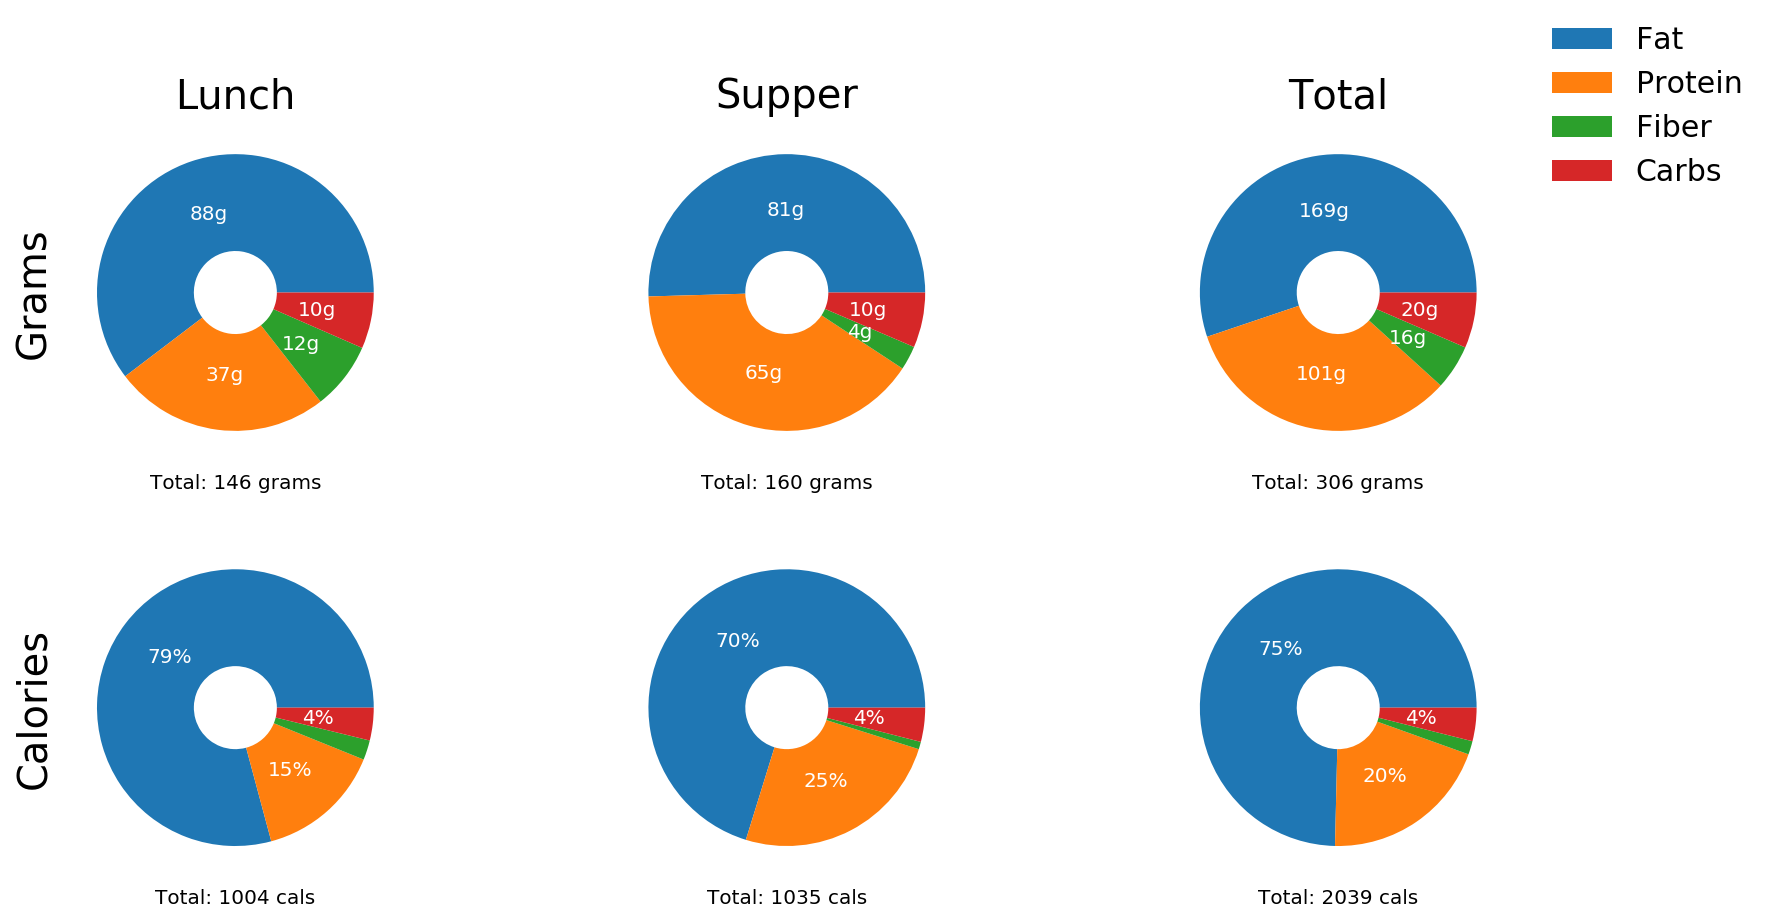

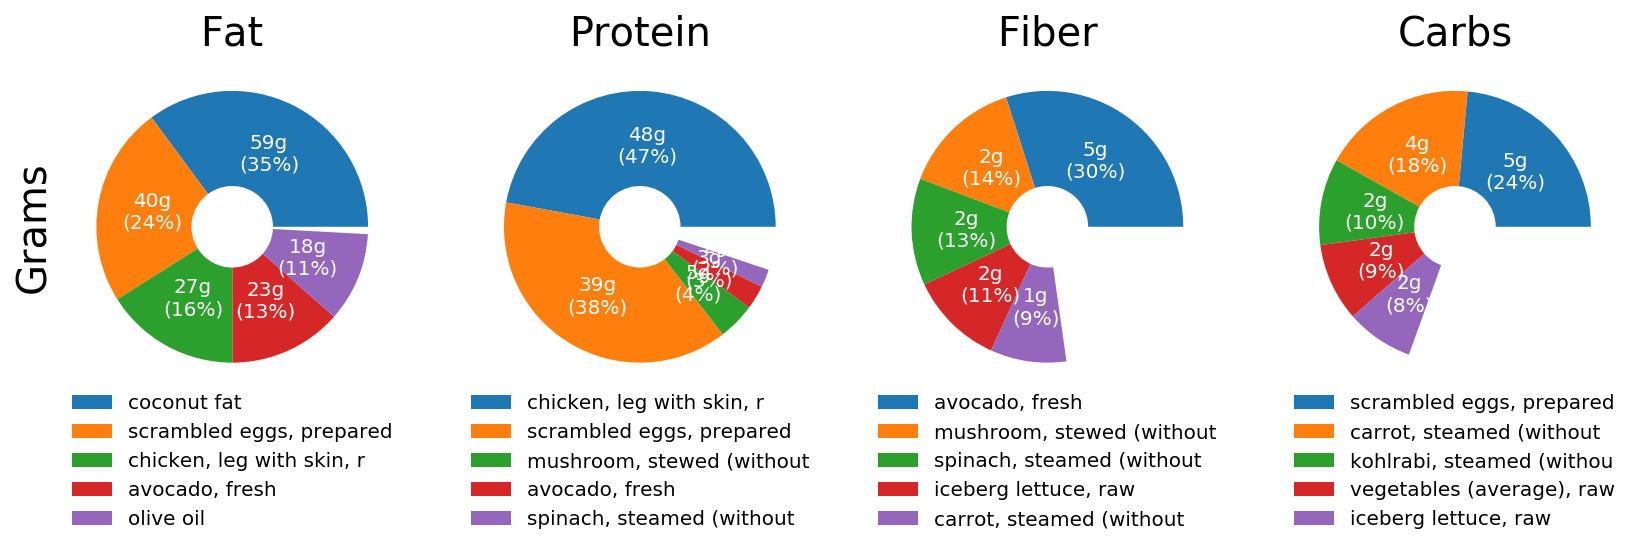

In [40]:
from foods.meals import molly_meals, fabian_meals

meal_data = make_data(fabian_meals, foods)
meal_plots(meal_data)
nuts_plots(meal_data)